In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
data = pd.read_csv("Iris.csv")

#### With dataframe.sapmle we shuffle the input data and we give a particular random_state(as a seed for random function) to this function to make the results comparable.

In [3]:
data = data.sample(frac=1, random_state=42)

In [4]:
feature_columns = data.columns[:4]
feature_columns

Index(['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'], dtype='object')

#### In normalize function we get a dataframe and subtract each columns mean from it and divide it to it's std so that it have mean=0 and std=1.

In [5]:
def normalize(df):
    new_df = df.copy()
    for col in feature_columns:
        new_df[col] -= df[col].mean()
        new_df[col] /= df[col].std()
    return new_df

#### Here we normalize the data so that will test the classifier for both data and normalized_data:

In [6]:
data_normalized = normalize(data)

#### We obtain the unique classes in target column with np.unique()

In [7]:
categories = np.unique(data["Class"])

#### Here we want to plot the distribution of the categories in each pair of features. First off we group the data by target column. Then In plot_columns we specify index of each pair of columns. and then we plot the specified features of the groups.

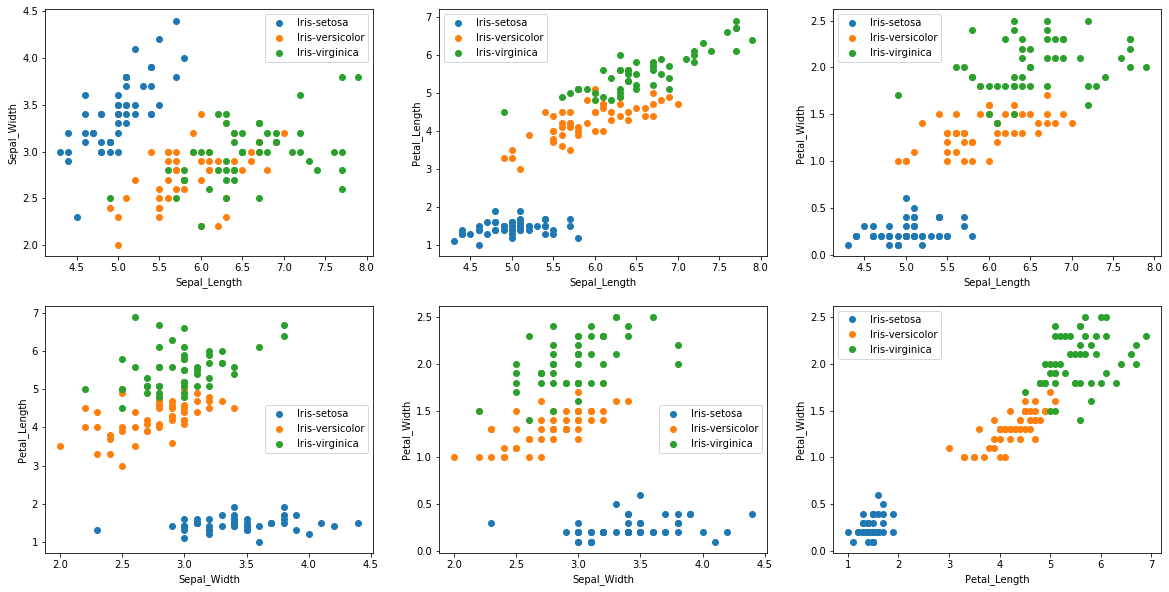

In [8]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
axes = axes.flat
groups = data.groupby("Class")
columns = data.columns
plot_columns = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

for i,p in enumerate(plot_columns):
    for name, group in groups:
        axes[i].plot(group[columns[p[0]]], group[columns[p[1]]], marker="o", linestyle="", label=name)
        axes[i].set_xlabel(columns[p[0]])
        axes[i].set_ylabel(columns[p[1]])
        axes[i].legend()

#### We can conclude from above plots that based on features Petal_Lenth and Petal_Width the three categories are more distinctivly and linearly separable so a lineaer classifier can have more accuracy based on these two features.

#### In train_test_splitter function we select  80% of data for training and 20% of data for testing.

In [9]:
def train_test_splitter(data_to_split):
    split_point =  int(0.8 * len(data_to_split))
    X_train = data_to_split.iloc[:split_point, [0,1,2,3]]
    y_train =  data_to_split.iloc[:split_point, [-1]]
    X_test = data_to_split.iloc[split_point:, [0,1,2,3]]
    y_test = data_to_split.iloc[split_point:, [-1]]
    return(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_splitter(data)
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_splitter(data_normalized)

#### We assign a unique integer for each class name(later it will help in more simple coding)

In [10]:
class_idx = {}
for i,c in enumerate(categories):
    class_idx[c] = i
class_idx

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

#### Here we build the classifier function. It uses Euclidian distance and for this reason it iterates over test samples and for each sample it subtracts the sample from all training samples and finds the square of the result. Then finds the minimum of them and then uses the closest point class as the prediction for current test sample. Meanwhile we compare the prediction result for each test point, for the real class of that point and if it is true we increment the 'corrects' variable which is 0 at first. 
#### Also we have an n by n confusion matrix which is initially zeros.  For each predicted class i and real class j we increment the matrix_ij to build the confusion matrix.
#### This classifier returns the accuracy and confusion matrix.

In [11]:
def nn_classify(X_train, X_test, y_train, y_test):
    
    conf_mtx = np.zeros((3,3))
    corrects = 0
    
    for i, _ in X_test.iterrows():
        diffs = X_train.loc[:, feature_columns] - X_test.loc[i, feature_columns].squeeze(0)
        nearest_index = diffs.pow(2).sum(axis=1).idxmin()
        
        prediction = y_train.loc[nearest_index, 'Class']
        real_class = y_test.loc[i, 'Class']
        
        conf_mtx[class_idx[prediction]][class_idx[real_class]] += 1
        
        if prediction == y_test.loc[i, 'Class']:
            corrects += 1
        
    accuracy = corrects/len(X_test) * 100
    return accuracy, conf_mtx

In [12]:
accuracy, conf_mtx = nn_classify(X_train, X_test, y_train, y_test)

### Accuracy and Confusoin Matrix

### Non-Normalized Data

In [13]:
print('accuracy of NN classifier for non-normalized data is:', round(accuracy), '%')

accuracy of NN classifier for non-normalized data is: 97 %


In [14]:
print('confusion matrix of NN classifier for non-normalized data is:')
print(conf_mtx)

confusion matrix of NN classifier for non-normalized data is:
[[ 7.  0.  0.]
 [ 0. 11.  1.]
 [ 0.  0. 11.]]


### Normalized Data

In [15]:
accuracy, conf_mtx = nn_classify(X_train_normal, X_test_normal, y_train_normal, y_test_normal)

In [16]:
print('accuracy of NN classifier for non-normalized data is:', round(accuracy), '%')

accuracy of NN classifier for non-normalized data is: 97 %


In [17]:
print('confusion matrix of NN classifier for non-normalized data is:')
print(conf_mtx)

confusion matrix of NN classifier for non-normalized data is:
[[ 7.  0.  0.]
 [ 0. 11.  1.]
 [ 0.  0. 11.]]


#### Now we want to calculate the presision, recall and f1-score for each target class. First we initiaze 3 arrays one for each. 

In [18]:
precisions = []
recalls = []
f1 = []

#### The we iterate over categories and calculate each metric for each category will following formula and append the result to the correspoing array:

$$
presisoin = \frac{TP}{TP + FP} \\
recall = \frac{TP}{TP + FN} \\
F1score = 2 \times \frac{recall \times presisoin}{recall + presicion}
$$

In [19]:
for i in range(len(categories)):
    precision = conf_mtx[i][i] / conf_mtx.sum(axis=1)[i]
    precisions.append(precision)
    
    recall = conf_mtx[i][i] / conf_mtx.sum(axis=0)[i]
    recalls.append(recall)
    f1.append(2 * (precision * recall) / (precision + recall))

In [20]:
for i in range(len(categories)):
    print('precision for class {} = {}'.format(categories[i], round(precisions[i], 3)))
    print('recall for class {} = {}'.format(categories[i], round(recalls[i])))
    print('F1-score for class {} = {}\n'.format(categories[i], round(f1[i])))

precision for class Iris-setosa = 1.0
recall for class Iris-setosa = 1.0
F1-score for class Iris-setosa = 1.0

precision for class Iris-versicolor = 0.917
recall for class Iris-versicolor = 1.0
F1-score for class Iris-versicolor = 1.0

precision for class Iris-virginica = 1.0
recall for class Iris-virginica = 1.0
F1-score for class Iris-virginica = 1.0



# Using Sklearn

In [21]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [22]:
data = pd.read_csv("Iris.csv")
data_normalized = normalize(data)

In [24]:
X = data[feature_columns]
y = data['Class']

X_normalized = data[feature_columns]
y_nomalized = data_normalized['Class']

#### Here we binarize each sample's class(also called one-hot, one-vs-rest) because we want to plot the roc for each class individually and sklearn roc plots only work for binary classifiction.

In [25]:
y = label_binarize(y, classes=y.unique())
y_normalized = label_binarize(y_nomalized, classes=y_nomalized.unique())

for example for first sample the target will be shown like [1,0,0] it means that it's target class is first class:

In [26]:
y[0] 

array([1, 0, 0])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_splitter(data_normalized)

#### Here we use KNeighborsClassifier with k = 1 to build a nearest neighbour classifier

In [28]:
knn = KNeighborsClassifier(n_neighbors=1)

## Non-Normalized Data

#### Now we fit the classifer to train data and predict the labels for test data.

In [29]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

#### We find the accurancy of the model with score function. We can see that the classifier has performed quite well on thNon-Normalized data:

In [30]:
knn.score(X_test, y_test) * 100

100.0

## Normalized Data

In [32]:
knn.fit(X_train_normal, y_train_normal)
y_pred = knn.predict(X_test_normal)

/home/amin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


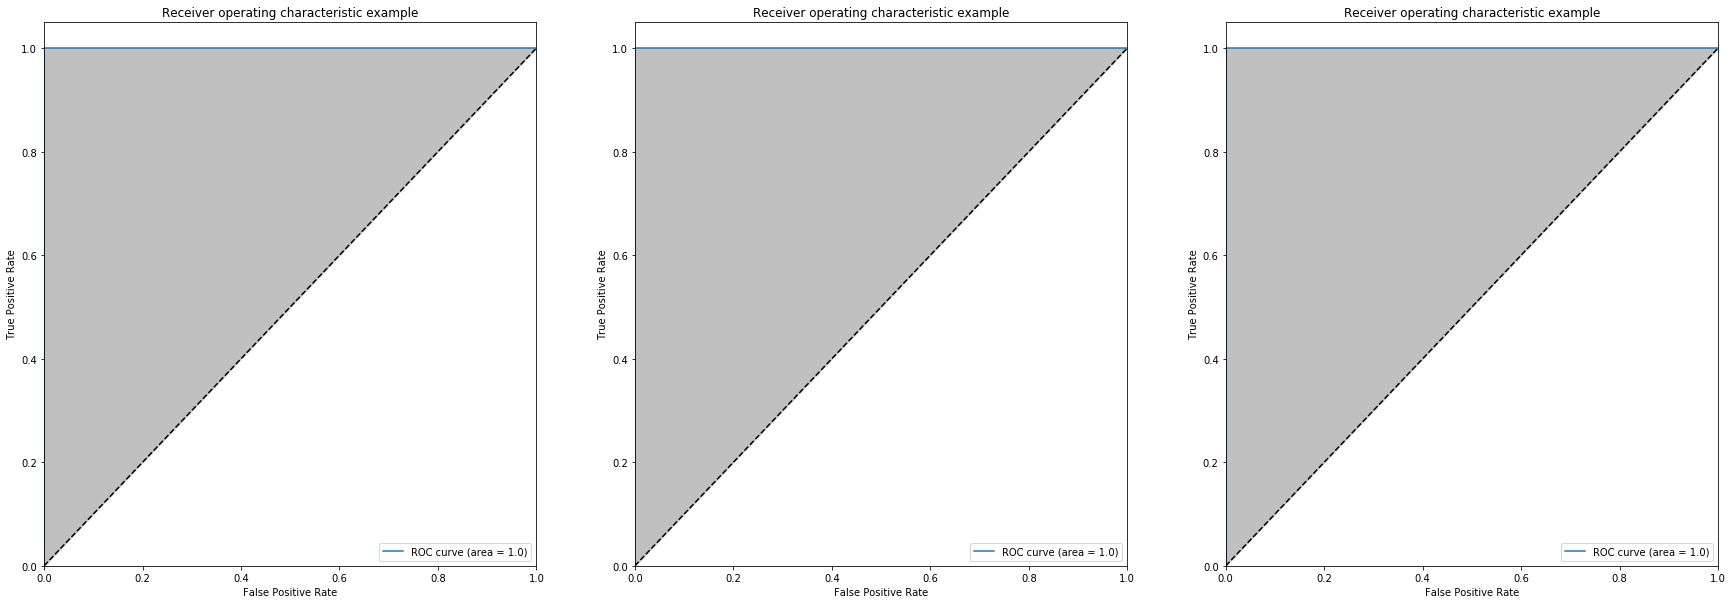

In [31]:
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
fig, axes = plt.subplots(1,3, figsize=(30,10))
axes = axes.flat
for i in range(n_classes):
    axes[i].plot(fpr[i], tpr[i], label='ROC curve (area = {})'.format(roc_auc[i]))
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].fill_between(fpr[i], fpr[i], tpr[i], 1, color='silver')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title('Receiver operating characteristic')
    axes[i].legend(loc="lower right")

In [ ]:
X = data_normalized[feature_columns]
y = data_normalized['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn.fit(X_train, y_train)
knn.score(X_test, y_test) * 100

In [ ]:
y_pred = pd.DataFrame(knn.predict(X_test))

In [ ]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
confusion = confusion_matrix(y_test, y_pred)
confusion